# INSTRUCTIONS

This file is designed to run with minimal user input. The code is divided into multiple steps and the user must execute the steps sequentially to produce results.

* **Section 1**: downloads the dataset automatically
* **Section 2**: imports all necessary libraries
* **Section 3**: creates all the necessary methods for experiments
* **Section 4**: executes the experiments to produce results
* **Section 5**: visualises the results

# STEP 1 - Download Dataset


Downloads dataset from repository, unzips and mounts to google drive

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
f = open('/content/drive/MyDrive/behaviour_biometrics_dataset/raw_kmt_dataset/raw_kmt_user_' + user_number + '.json')

<_io.TextIOWrapper name='/content/drive/MyDrive/behaviour_biometrics_dataset/raw_kmt_dataset/raw_kmt_user_0001.json' mode='r' encoding='UTF-8'>


In [17]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

dataset_name = 'behaviour_biometrics_dataset'

!ls

Mounted at /content/drive/
behaviour_biometrics_dataset.zip  drive  sample_data


# STEP 2 - Libraries


Imports the key libraries used within this .IPYNB file.

In [2]:
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
import json
import pandas as pd
import math

# STEP 3 - Core Methods

Executes the methods necessary to run experiments

In [3]:
# CONVERTS DICTIONARIES TAKEN FROM .JSON FILES INTO DATAFRAMES FOR THE KEY EVENTS
def dict_key_conversion(data):
    temp_df = pd.DataFrame(columns=['test_number', 'dwell_time', 'flight_time', 'key_pressed'])
    temp_flight_df = pd.DataFrame(columns=['test_number', 'flight_time', 'key_released'])

    temp_df_count = 0 # indicates which row of the df the next row of data should be appeneded into
    temp_flight_df_count = 0

    for i in range(1, 11): # loops through each of the tests in true_data
        k_data = data['test_'+str(i)]['key_events']
        # removes tabs from the data, as kivy, which is the library used for data collection, doesn't register tab releases, only presses
        tabless_k_data = []
        for k in k_data:
            if k['Key'] != 'tab':
                tabless_k_data.append(k)

        count = 0 #counter for how many iterations into the for loop it is
        f_count = 0 #counter for how many iterations into the loop the flight section has done
        prev_key_press = 0
        prev_key_release = 0
        for j in tabless_k_data:
            if j['Event'] == 'pressed': # THIS EXECUTES TO FIND THE DWELL TIME
                flight_impute = 0 # imputes flight time as 0 for now, as there are instances of key presses not having releases at the end of the test
                key_id = j['Key'] # this is what the actual key that is being pressed/released is
                key_press_time = j['Epoch'] # the epoch time of the key press
                key_release = False # is true when the release of the key has been found
                cont_count = 1 # keeps track of counting from the current key press, as it loops from

                while key_release == False: # continues
                    c = cont_count + count
                    start_row = tabless_k_data[count]
                    next_row = tabless_k_data[c]
                    # executes if the row is the release of the key that was pressed, and exits the while loop
                    if next_row['Key'] == key_id and next_row['Event'] == 'released':
                        key_release_time = next_row['Epoch']
                        dwell_time = float(key_release_time) - float(key_press_time)
                        key_release = True
                    # executes if the next row is a press event for a different key
                    elif next_row['Key'] != key_id and next_row['Event'] == 'pressed':
                        cont_count += 1
                    elif next_row['Key'] != key_id and next_row['Event'] == 'released':
                        cont_count += 1
                    else:
                        key_release = True
                        dwell_time = 0
                        key_release_time = start_row['Epoch']

                temp_df.loc[temp_df_count] = [i, dwell_time, flight_impute, key_id]

                prev_key_press = key_press_time
                prev_key_release = key_release_time
                temp_df_count += 1

            count += 1

            if j['Event'] == 'released': # THIS EXECUTES TO FIND THE FLIGHT TIME
                key_id = j['Key']
                f_cont_count = 1
                flight_time = []
                flight_found = False
                while flight_found == False:
                    f_c = f_count + f_cont_count
                    if f_c < len(tabless_k_data):
                        next_row = tabless_k_data[f_c]
                        if next_row['Event'] == 'pressed' and next_row['Key'] != key_id:
                            flight_time = float(next_row['Epoch']) - float(j['Epoch'])
                            temp_flight_df.loc[temp_flight_df_count] = [i, flight_time, key_id]
                            temp_flight_df_count += 1
                            flight_found = True
                        f_cont_count += 1
                    else:
                        flight_found = True
            f_count += 1

    # Now merges the flight time df with the rest of the features
    for i in range(1, 11):
        fh_count = 0
        flight_hold = []
        for j in temp_flight_df.index:
            if temp_flight_df.at[j, 'test_number'] == i:
                flight_hold.append(temp_flight_df.at[j, 'flight_time'])
        fh_count = 0

        for j in temp_df.index:
            if temp_df.at[j, 'test_number'] == i and fh_count < len(flight_hold):
                temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
                fh_count += 1

    true_k_df = temp_df
    return true_k_df

In [4]:
# CONVERTS DICTIONARIES TAKEN FROM .JSON FILES INTO DATAFRAMES FOR THE MOUSE EVENTS
def get_distance(a, b): # method used to calculate distance between two coordinates
    distance = math.sqrt(((a[0] - b[0]) ** 2) + ((a[1] - b[1]) ** 2))
    return distance

def dict_mouse_conversion(data):
    m_df = pd.DataFrame(columns = ['test_number', 'movement_id', 'trajectory', 'single_coor'])
    row_count = 0
    for i in range(1, 11):
        m_data = data['test_'+str(i)]['mouse_events']
        m_movements = []
        for j in m_data[:len(m_data)-1]:
            if j['Event'] == 'movement':
                m_movements.append(j)

        # creates dictionary that passes all the movement coordinates to the each movement ID in the test
        movement_coor_dict = {}
        for j in m_movements:
            movement_coor_dict[j['Movement ID']] = []
        for j in m_movements:
            movement_coor_dict[j['Movement ID']].append(j['Coordinates'])

        # calculates the overall trajectory length for each of the movement IDs
        for j in movement_coor_dict:
            coor_list = movement_coor_dict[j]
            motion_start = False
            trajectory = 0
            if len(coor_list) > 1:
                trajectory_list = []
                if motion_start == True:
                    motion_start = False
                else:
                    count = 0
                    for k in coor_list:
                        trajectory_list.append(get_distance(coor_list[count-1], coor_list[count]))
                        count += 1
                    movement_id = j
                    trajectory = sum(trajectory_list)
                    single_coor = False
            else:
                movement_id = 1
                trajectory_list = [0]
                trajectory = 0
                single_coor = False
            m_df.loc[row_count] = [i, movement_id, trajectory, single_coor]
            row_count += 1
    m_df = m_df.sort_values(by=['test_number', 'movement_id'])

    for j in m_df['single_coor'].tolist():
        if j == True:
            m_df = movement_df.drop[count]
        count += 1
    m_df = m_df.reset_index(drop=True)
    return m_df

In [5]:
# GENERATES FEATURES FOR EACH TEST FROM THE DFS GENERATED IN THE PREVIOUS TWO CELLS
def feature_gen(k_data, m_data):
    columns = ['dwell_avg', 'flight_avg', 'traj_avg']

    df = pd.DataFrame(columns=columns)

    # for loop calculates average value for the dwell time, flight time and trajectory for each test
    for i in range(1, 11):
        dwell_list = []
        flight_list = []
        traj_list = []
        for j in k_data.index:
            if k_data.at[j, 'test_number'] == i:
                dwell_list.append(k_data.at[j, 'dwell_time'])
                flight_list.append(k_data.at[j, 'flight_time'])
        for j in m_data.index:
            if m_data.at[j, 'test_number'] == i:
                traj_list.append(m_data.at[j, 'trajectory'])

        dwell_list = [j for j in dwell_list if j != 0]
        flight_list = [j for j in flight_list if j != 0]
        traj_list = [j for j in traj_list if j != 0]

        dwell_avg = sum(dwell_list)/len(dwell_list)
        flight_avg = sum(flight_list)/len(dwell_list)
        traj_avg = sum(traj_list)/len(traj_list)


        agg_data = [dwell_avg, flight_avg, traj_avg]

        df.loc[i] = agg_data
    return df

# STEP 4 - Experiments & Results



Loads the raw .json files from google drive, generates features for ML classification task, and evaluates the models.

In [10]:
!ls /content/drive/MyDrive/behaviour_biometrics_dataset/raw_kmt_dataset/

ls: cannot access '/content/drive/MyDrive/behaviour_biometrics_dataset/raw_kmt_dataset/': No such file or directory


In [27]:
# Temporary list storage for visualisation
acc_list = []
fm_list = []
# RUNS THE MODEL ON EACH OF THE USER'S DATA

for i in range(1, 89):
    # stores each of the true data as dictionaries
    user_number = i
    user_number = str(user_number).zfill(4)
    f = open('/content/drive/MyDrive/behaviour_biometrics_dataset/raw_kmt_dataset/raw_kmt_user_' + user_number + '.json')
    data = json.load(f)
    user_details = data['details'] # stores the fabricated card details entered for the user
    true_data = data['true_data'] # stores the true data of the .json file
    false_data = data ['false_data']
    #----------------------------------
    true_k_df = dict_key_conversion(true_data) # gets the key events from the json files
    false_k_df = dict_key_conversion(false_data)

    true_m_df = dict_mouse_conversion(true_data) # gets the mouse events from the json files
    false_m_df = dict_mouse_conversion(false_data)
    #----------------------------------
    true_df = feature_gen(true_k_df, true_m_df) # gets the average dwell, flight and traj for each test
    false_df = feature_gen(false_k_df, false_m_df)
    true_df['label'] = 1 # adds true or false label to the df for the ML algorithm, 1 == true, 0 == false
    false_df['label'] = 0
    final_df = pd.concat([true_df, false_df])
    final_df = final_df.reset_index(drop=True) # final df that will be used within the ML algorithm
    #----------------------------------
    y = final_df['label'].tolist() # carries out the train test split and the ML prediction
    X = final_df.drop(['label'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    clf = tree.DecisionTreeClassifier()
    clf.fit(X_train, y_train)
    predicted_labels = clf.predict(X_test)
    clf_rep = classification_report(y_test, predicted_labels, output_dict=True)
    acc = clf_rep['accuracy']
    fm = clf_rep['weighted avg']['f1-score']
    print('User', i)
    print('Target Labels', y_test)
    print('Predicted Labels', predicted_labels)
    print('Accuracy:', acc)
    print('Fm:', fm)
    print('----------------------------')

    acc_list.append(acc)
    fm_list.append(fm)



final_acc = sum(acc_list)/len(acc_list)
final_fm = sum(fm_list)/len(fm_list)


print(' ')
print('###########################')
print('##########RESULTS##########')
print('###########################')
print('Accuracy:', final_acc)
print('F-Measure:', final_fm)

<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.12411165237426758' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.15212512016296387' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 1
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 1 1]
Accuracy: 0.75
Fm: 0.7333333333333334
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.08805513381958008' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1383669376373291' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 2
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 0 1]
Accuracy: 0.75
Fm: 0.7333333333333334
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.9563541412353516' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.16317152976989746' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 3
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
Fm: 1.0
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.1194884777069092' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1795940399169922' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 4
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 0 1]
Accuracy: 0.75
Fm: 0.7333333333333334
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.4791879653930664' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.15119242668151855' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 5
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
Fm: 1.0
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.12276649475097656' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.16077613830566406' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 6
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
Fm: 1.0
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0853428840637207' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.063201904296875' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 7
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
Fm: 1.0
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.19540166854858398' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2864551544189453' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist

User 8
Target Labels [0, 1, 0, 1]
Predicted Labels [0 0 0 0]
Accuracy: 0.5
Fm: 0.3333333333333333
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.133925199508667' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.12450909614562988' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 9
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 1 0]
Accuracy: 0.5
Fm: 0.5
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.31940793991088867' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1496434211730957' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 10
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 0 1]
Accuracy: 0.75
Fm: 0.7333333333333334
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.29933738708496094' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1271071434020996' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist

User 11
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 1 1]
Accuracy: 0.5
Fm: 0.3333333333333333
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.4757719039916992' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.46568727493286133' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 12
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 1 1]
Accuracy: 0.75
Fm: 0.7333333333333334
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.07256126403808594' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1841874122619629' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 13
Target Labels [0, 1, 0, 1]
Predicted Labels [0 0 0 1]
Accuracy: 0.75
Fm: 0.7333333333333334
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.1852333545684814' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.15816020965576172' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist

User 14
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 1 1]
Accuracy: 0.5
Fm: 0.3333333333333333
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.2887649536132812' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5705454349517822' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 15
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 0]
Accuracy: 0.75
Fm: 0.7333333333333334
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8196535110473633' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.4267761707305908' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-

User 16
Target Labels [0, 1, 0, 1]
Predicted Labels [0 0 0 0]
Accuracy: 0.5
Fm: 0.3333333333333333
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.220979690551758' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5863356590270996' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-p

User 17
Target Labels [0, 1, 0, 1]
Predicted Labels [0 0 0 0]
Accuracy: 0.5
Fm: 0.3333333333333333
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.695796012878418' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.19422054290771484' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 18
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
Fm: 1.0
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.31594038009643555' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.25921034812927246' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 19
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 0 1]
Accuracy: 0.75
Fm: 0.7333333333333334
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.011690855026245117' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.31609296798706055' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 20
Target Labels [0, 1, 0, 1]
Predicted Labels [0 0 0 1]
Accuracy: 0.75
Fm: 0.7333333333333334
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9523496627807617' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1715555191040039' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 21
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
Fm: 1.0
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0638279914855957' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2194206714630127' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 22
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 1 1]
Accuracy: 0.75
Fm: 0.7333333333333334
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.03761148452758789' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.36469507217407227' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 23
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
Fm: 1.0
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.681654691696167' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.18199610710144043' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 24
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
Fm: 1.0
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1470491886138916' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.07248282432556152' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 25
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 1 1]
Accuracy: 0.75
Fm: 0.7333333333333334
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.21784615516662598' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.047876596450805664' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 26
Target Labels [0, 1, 0, 1]
Predicted Labels [0 0 1 1]
Accuracy: 0.5
Fm: 0.5
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.21860790252685547' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.12124300003051758' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 27
Target Labels [0, 1, 0, 1]
Predicted Labels [1 0 0 1]
Accuracy: 0.5
Fm: 0.5
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.28124427795410156' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.03659462928771973' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 28
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 1 1]
Accuracy: 0.75
Fm: 0.7333333333333334
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.3142547607421875' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.11169886589050293' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 29
Target Labels [0, 1, 0, 1]
Predicted Labels [0 0 0 1]
Accuracy: 0.75
Fm: 0.7333333333333334
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.92722487449646' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.14404749870300293' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 30
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
Fm: 1.0
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.28079676628112793' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.12222647666931152' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 31
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
Fm: 1.0
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.35746049880981445' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.060411691665649414' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/di

User 32
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 1 1]
Accuracy: 0.5
Fm: 0.3333333333333333
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '101.78151321411133' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.02445220947265625' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 33
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 0]
Accuracy: 0.75
Fm: 0.7333333333333334
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.7329318523406982' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0508570671081543' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-

User 34
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 1 1]
Accuracy: 0.5
Fm: 0.3333333333333333
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.08403158187866211' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.10991692543029785' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 35
Target Labels [0, 1, 0, 1]
Predicted Labels [1 0 0 0]
Accuracy: 0.25
Fm: 0.2
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1219332218170166' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.35562705993652344' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist

User 36
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 1 1]
Accuracy: 0.5
Fm: 0.3333333333333333
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.4653513431549072' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3167126178741455' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 37
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 1 1]
Accuracy: 0.75
Fm: 0.7333333333333334
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.19015121459960938' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.4057347774505615' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 38
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
Fm: 1.0
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.07579731941223145' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.31242918968200684' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dis

User 39
Target Labels [0, 1, 0, 1]
Predicted Labels [0 0 0 0]
Accuracy: 0.5
Fm: 0.3333333333333333
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.12299203872680664' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2316608428955078' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 40
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
Fm: 1.0
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3674163818359375' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1463470458984375' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 41
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
Fm: 1.0
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.37890195846557617' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.29478955268859863' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 42
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 1 1]
Accuracy: 0.75
Fm: 0.7333333333333334
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.7252004146575928' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.47917962074279785' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 43
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 0 1]
Accuracy: 0.75
Fm: 0.7333333333333334
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1275620460510254' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.36507344245910645' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 44
Target Labels [0, 1, 0, 1]
Predicted Labels [0 0 0 1]
Accuracy: 0.75
Fm: 0.7333333333333334
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.20032191276550293' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5027735233306885' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 45
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
Fm: 1.0
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5629923343658447' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.05055880546569824' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 46
Target Labels [0, 1, 0, 1]
Predicted Labels [0 0 1 1]
Accuracy: 0.5
Fm: 0.5
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.37174344062805176' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.13625764846801758' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 47
Target Labels [0, 1, 0, 1]
Predicted Labels [0 0 0 1]
Accuracy: 0.75
Fm: 0.7333333333333334
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8200299739837646' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.13542437553405762' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 48
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
Fm: 1.0
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9999668598175049' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.12293100357055664' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 49
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 0]
Accuracy: 0.75
Fm: 0.7333333333333334
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.591892242431641' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.4898402690887451' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 50
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 0]
Accuracy: 0.75
Fm: 0.7333333333333334
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0284154415130615' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.06281089782714844' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 51
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 0 1]
Accuracy: 0.75
Fm: 0.7333333333333334
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.21469616889953613' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.27518439292907715' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 52
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 0 1]
Accuracy: 0.75
Fm: 0.7333333333333334
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.04952883720397949' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.061274051666259766' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 53
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 1 1]
Accuracy: 0.75
Fm: 0.7333333333333334
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.6493418216705322' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.11600923538208008' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 54
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
Fm: 1.0
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.7238674163818359' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5130228996276855' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 55
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
Fm: 1.0
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.104879379272461' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.475451707839966' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 56
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 0 0]
Accuracy: 0.5
Fm: 0.5
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.046738147735596' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.6852021217346191' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 57
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
Fm: 1.0
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1967623233795166' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8153324127197266' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 58
Target Labels [0, 1, 0, 1]
Predicted Labels [0 0 0 1]
Accuracy: 0.75
Fm: 0.7333333333333334
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9516057968139648' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1844491958618164' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 59
Target Labels [0, 1, 0, 1]
Predicted Labels [1 0 1 1]
Accuracy: 0.25
Fm: 0.2
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.06059575080871582' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8478474617004395' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 60
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
Fm: 1.0
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.7394251823425293' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '8.456364154815674' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 61
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
Fm: 1.0
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5692200660705566' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.20771098136901855' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 62
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 0 1]
Accuracy: 0.75
Fm: 0.7333333333333334
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5913362503051758' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.23249220848083496' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 63
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 0]
Accuracy: 0.75
Fm: 0.7333333333333334
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.441004753112793' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5392920970916748' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 64
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
Fm: 1.0
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.83546781539917' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.48987627029418945' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 65
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
Fm: 1.0
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9205794334411621' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.011719226837158203' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 66
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 0 0]
Accuracy: 0.5
Fm: 0.5
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.15563464164733887' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.16076445579528809' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 67
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
Fm: 1.0
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.31180667877197266' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.7324285507202148' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 68
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
Fm: 1.0
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.15170836448669434' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.13246917724609375' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 69
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 1 1]
Accuracy: 0.75
Fm: 0.7333333333333334
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.08758139610290527' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.21863317489624023' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 70
Target Labels [0, 1, 0, 1]
Predicted Labels [0 0 0 1]
Accuracy: 0.75
Fm: 0.7333333333333334
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.03696608543395996' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.13496160507202148' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 71
Target Labels [0, 1, 0, 1]
Predicted Labels [1 0 0 1]
Accuracy: 0.5
Fm: 0.5
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1363363265991211' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.25445985794067383' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 72
Target Labels [0, 1, 0, 1]
Predicted Labels [0 0 0 1]
Accuracy: 0.75
Fm: 0.7333333333333334
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.850924253463745' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.07369208335876465' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 73
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
Fm: 1.0
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1456916332244873' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.23178458213806152' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 74
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 1 1]
Accuracy: 0.75
Fm: 0.7333333333333334
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.28583669662475586' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.23052191734313965' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dis

User 75
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 1 1]
Accuracy: 0.5
Fm: 0.3333333333333333
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.03721141815185547' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2305440902709961' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 76
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 0 1]
Accuracy: 0.75
Fm: 0.7333333333333334
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.31116700172424316' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.24280548095703125' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 77
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 1 1]
Accuracy: 0.75
Fm: 0.7333333333333334
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0010013580322265625' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3568534851074219' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 78
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
Fm: 1.0
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.45618629455566406' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.024073123931884766' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 79
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
Fm: 1.0
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.39807581901550293' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.036962270736694336' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 80
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
Fm: 1.0
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.398696184158325' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1761631965637207' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 81
Target Labels [0, 1, 0, 1]
Predicted Labels [0 0 1 1]
Accuracy: 0.5
Fm: 0.5
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.6160075664520264' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.03802084922790527' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 82
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 1 1]
Accuracy: 0.75
Fm: 0.7333333333333334
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.349229097366333' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1909656524658203' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 83
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 1 0]
Accuracy: 0.5
Fm: 0.5
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.154421806335449' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.03709220886230469' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 84
Target Labels [0, 1, 0, 1]
Predicted Labels [1 0 1 1]
Accuracy: 0.25
Fm: 0.2
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.06066179275512695' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.4990246295928955' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 85
Target Labels [0, 1, 0, 1]
Predicted Labels [1 0 0 1]
Accuracy: 0.5
Fm: 0.5
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.2147762775421143' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.04974937438964844' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 86
Target Labels [0, 1, 0, 1]
Predicted Labels [1 1 0 1]
Accuracy: 0.75
Fm: 0.7333333333333334
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6.351594924926758' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.025191068649291992' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 87
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
Fm: 1.0
----------------------------


<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9692249298095703' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]
<ipython-input-3-8a26ce10022a>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.049141645431518555' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.at[j, 'flight_time'] = flight_hold[fh_count]


User 88
Target Labels [0, 1, 0, 1]
Predicted Labels [0 1 0 1]
Accuracy: 1.0
Fm: 1.0
----------------------------
 
###########################
##########RESULTS##########
###########################
Accuracy: 0.7613636363636364
F-Measure: 0.7340909090909093


# STEP 5 - Visualisation


Provides visual representation of the experimental data (frame) and results

In [28]:
final_df # displays the last df that was passed to the ML algorithm

,dwell_avg,flight_avg,traj_avg,label
0,0.147207,2.751204,574.530501,1
1,0.151566,1.510618,467.405409,1
2,0.160485,0.831984,633.774855,1
3,0.160635,0.872912,590.144207,1
4,0.151265,0.962310,430.895533,1
5,0.146313,0.870686,538.250621,1
6,0.148424,0.791336,578.814630,1
7,0.145037,0.705678,462.138789,1
8,0.154299,0.950675,452.602328,1
9,0.148347,0.723206,460.564528,1


(-0.1, 1.1)

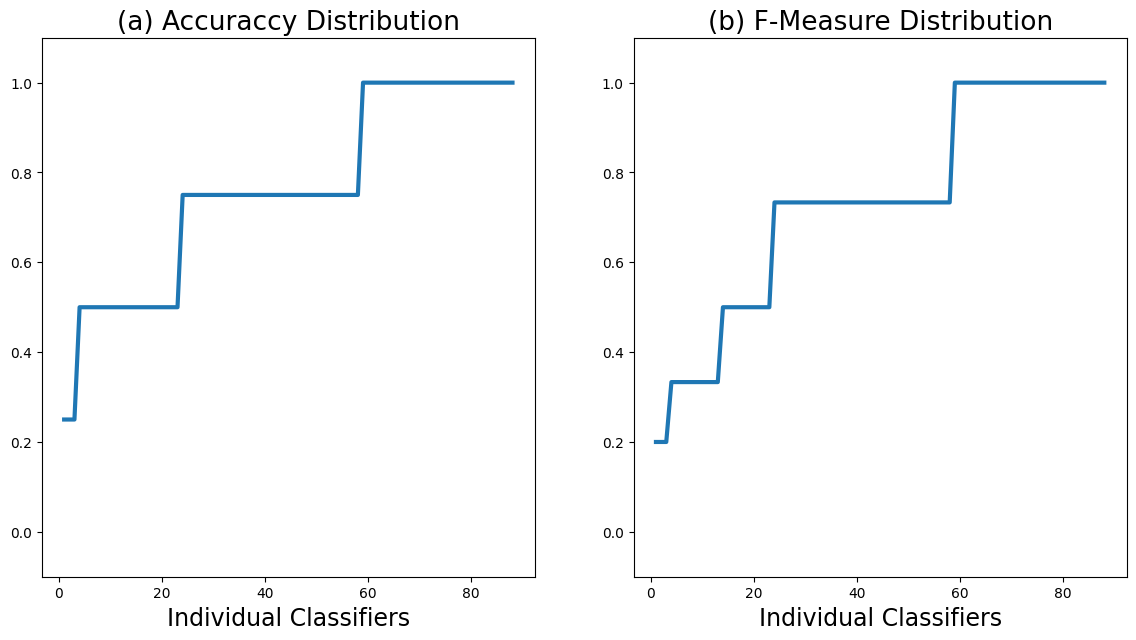

In [29]:
acc_list.sort()
fm_list.sort()
ind_class = []
for i in range(1, 89):
  ind_class.append(i)

f = plt.figure(figsize=(14, 7))

ax = f.add_subplot(121)
ax.plot(ind_class, acc_list, linewidth=3)
ax.set_title('(a) Accuraccy Distribution', fontsize=19)
ax.set_xlabel('Individual Classifiers', fontsize=17)
ax.set_ylim(-.1, 1.1)

ax2 = f.add_subplot(122)
ax2.plot(ind_class, fm_list, linewidth=3)
ax2.set_title('(b) F-Measure Distribution', fontsize=19)
ax2.set_xlabel('Individual Classifiers', fontsize=17)
ax2.set_ylim(-.1, 1.1)

# **Frequency of Interactions**

 1. Modifying dict_key_conversion to Count Key Interactions:

In the function dict_key_conversion, we will add a new counter (key_interactions_count) that counts key press/release events.

In [30]:
def dict_key_conversion(data):
    temp_df = pd.DataFrame(columns=['test_number', 'dwell_time', 'flight_time', 'key_pressed'])
    temp_flight_df = pd.DataFrame(columns=['test_number', 'flight_time', 'key_released'])

    temp_df_count = 0
    temp_flight_df_count = 0
    key_interactions_count = 0  # Counter for key interactions

    for i in range(1, 11):
        k_data = data['test_'+str(i)]['key_events']
        tabless_k_data = [k for k in k_data if k['Key'] != 'tab']

        for j in tabless_k_data:
            if j['Event'] in ['pressed', 'released']:  # Count both key presses and releases
                key_interactions_count += 1

            # Existing logic for dwell time and flight time continues here...

    true_k_df = temp_df
    return true_k_df, key_interactions_count  # Return the count along with the dataframe


# 2. Modifying dict_mouse_conversion to Count Mouse Interactions:
In the function dict_mouse_conversion, we will add a new counter (mouse_interactions_count) to count mouse movements.

In [31]:
def dict_mouse_conversion(data):
    m_df = pd.DataFrame(columns = ['test_number', 'movement_id', 'trajectory', 'single_coor'])
    row_count = 0
    mouse_interactions_count = 0  # Counter for mouse interactions

    for i in range(1, 11):
        m_data = data['test_'+str(i)]['mouse_events']
        m_movements = [j for j in m_data[:len(m_data)-1] if j['Event'] == 'movement']

        mouse_interactions_count += len(m_movements)  # Count the number of mouse movements

        # Existing logic for movement trajectory continues here...

    m_df = m_df.reset_index(drop=True)
    return m_df, mouse_interactions_count  # Return the count along with the dataframe


# 3. Adjusting the Main Experiment Code to Include Interaction Counts:

We now need to adjust the main experiment loop to handle the interaction counts returned by the modified functions. We'll add the interaction counts as features in the feature_gen function.

In [32]:
# Modify the feature_gen function to include interaction counts
def feature_gen(k_data, m_data, key_interactions, mouse_interactions):
    columns = ['dwell_avg', 'flight_avg', 'traj_avg', 'key_interactions', 'mouse_interactions']

    df = pd.DataFrame(columns=columns)

    for i in range(1, 11):
        dwell_list = []
        flight_list = []
        traj_list = []

        for j in k_data.index:
            if k_data.at[j, 'test_number'] == i:
                dwell_list.append(k_data.at[j, 'dwell_time'])
                flight_list.append(k_data.at[j, 'flight_time'])
        for j in m_data.index:
            if m_data.at[j, 'test_number'] == i:
                traj_list.append(m_data.at[j, 'trajectory'])

        # Average calculations
        dwell_avg = sum(dwell_list) / len(dwell_list) if dwell_list else 0
        flight_avg = sum(flight_list) / len(flight_list) if flight_list else 0
        traj_avg = sum(traj_list) / len(traj_list) if traj_list else 0

        # Add the interaction counts for each test
        agg_data = [dwell_avg, flight_avg, traj_avg, key_interactions, mouse_interactions]

        df.loc[i] = agg_data

    return df


# 4. Updating the Experiment Loop:

The experiment loop is updated to extract the number of key and mouse interactions for each user using modified dict_key_conversion and dict_mouse_conversion functions. These interaction counts are added as new features in the feature_gen function, alongside dwell time, flight time, and trajectory, before training the Decision Tree model.


In [34]:
# RUNS THE MODEL ON EACH OF THE USER'S DATA
for i in range(1, 89):
    user_number = str(i).zfill(4)
    f = open('/content/drive/MyDrive/behaviour_biometrics_dataset/raw_kmt_dataset/raw_kmt_user_' + user_number + '.json')
    data = json.load(f)

    true_data = data['true_data']
    false_data = data['false_data']

    # Get key and mouse events along with interaction counts
    true_k_df, true_key_interactions = dict_key_conversion(true_data)
    false_k_df, false_key_interactions = dict_key_conversion(false_data)

    true_m_df, true_mouse_interactions = dict_mouse_conversion(true_data)
    false_m_df, false_mouse_interactions = dict_mouse_conversion(false_data)

    # Generate features including interaction counts
    true_df = feature_gen(true_k_df, true_m_df, true_key_interactions, true_mouse_interactions)
    false_df = feature_gen(false_k_df, false_m_df, false_key_interactions, false_mouse_interactions)

    # Label data
    true_df['label'] = 1
    false_df['label'] = 0

    final_df = pd.concat([true_df, false_df]).reset_index(drop=True)

    # Train-test split and model training
    y = final_df['label'].tolist()
    X = final_df.drop(['label'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    clf = tree.DecisionTreeClassifier()
    clf.fit(X_train, y_train)
    predicted_labels = clf.predict(X_test)

    # Existing code for accuracy and F1-score calculations continues here...


In [35]:
# Display the final dataframe with new features (including interaction counts)
display(final_df.head())  # Show the first few rows of the final DataFrame


print("User", i, "Key Interactions:", true_key_interactions, "Mouse Interactions:", true_mouse_interactions)





,dwell_avg,flight_avg,traj_avg,key_interactions,mouse_interactions,label
0,0,0,0,1013,3564,1
1,0,0,0,1013,3564,1
2,0,0,0,1013,3564,1
3,0,0,0,1013,3564,1
4,0,0,0,1013,3564,1


User 88 Key Interactions: 1013 Mouse Interactions: 3564


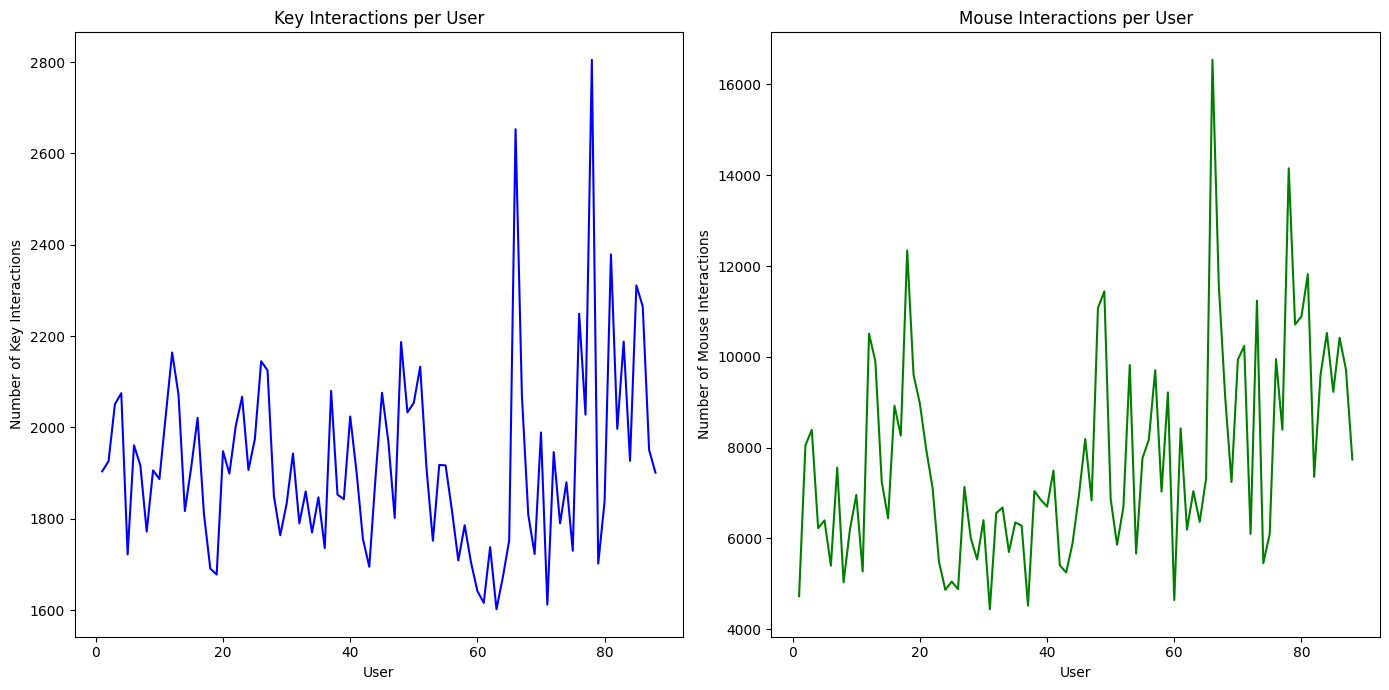

In [37]:
# Lists to store interaction counts for visualization
key_interaction_list = []
mouse_interaction_list = []

for i in range(1, 89):
    user_number = str(i).zfill(4)
    f = open('/content/drive/MyDrive/behaviour_biometrics_dataset/raw_kmt_dataset/raw_kmt_user_' + user_number + '.json')
    data = json.load(f)

    true_data = data['true_data']
    false_data = data['false_data']

    # Get key and mouse events along with interaction counts
    true_k_df, true_key_interactions = dict_key_conversion(true_data)
    false_k_df, false_key_interactions = dict_key_conversion(false_data)

    true_m_df, true_mouse_interactions = dict_mouse_conversion(true_data)
    false_m_df, false_mouse_interactions = dict_mouse_conversion(false_data)

    # Append the interaction counts for plotting
    key_interaction_list.append(true_key_interactions + false_key_interactions)
    mouse_interaction_list.append(true_mouse_interactions + false_mouse_interactions)

# Plot the interaction counts
plt.figure(figsize=(14, 7))
plt.subplot(121)
plt.plot(range(1, 89), key_interaction_list, label='Key Interactions', color='blue')
plt.title('Key Interactions per User')
plt.xlabel('User')
plt.ylabel('Number of Key Interactions')

plt.subplot(122)
plt.plot(range(1, 89), mouse_interaction_list, label='Mouse Interactions', color='green')
plt.title('Mouse Interactions per User')
plt.xlabel('User')
plt.ylabel('Number of Mouse Interactions')

plt.tight_layout()
plt.show()
